In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import json
import os

keyword = "Normal"
path = "SurfaceData/surfaceParams" + keyword + ".json"
def load_params(path = path):
    with open(path, "r") as f:
        return json.load(f)
params = load_params()

# Cell and resolution
pml_thickness = params["pml_thickness"]
monitor_size = params["monitor_size"]
half_x = params["halfWidth_x"]
half_y = params["halfWidth_y"]
half_z = params["halfWidth_z"]
cell_size = mp.Vector3(2*half_x + 2*pml_thickness,
                       2*half_y + 2*pml_thickness,
                       2*half_z + 2*pml_thickness)

omega = params["omega"]
betas = params["betas"]
# Material
epsilon1 = params["epsilon1"] 
substrate = mp.Medium(epsilon = epsilon1)
bumps = []

## Must be at least 8 pixels per smallest wavelength, i.e. np.floor(8/wvl_min)
resolution = params["resolution"]

frq = params["omega"]/(2*np.pi)
wvl = 1 / frq

pml_layers = [mp.PML(thickness=pml_thickness)] 

def make_source(component):
    return [mp.Source(
        mp.GaussianSource(frequency=frq, fwidth=1, is_integrated=True),
        center=mp.Vector3(0, 0, half_z - 0.5),
        size=mp.Vector3(cell_size[0], cell_size[1], 0),
        component=component
    )]

def run_meep_simulation(sources):
    # Reference simulation (no bumps)
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
    )

    box1_x1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box1_x2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(x=+monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box1_y1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(y=-monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box1_y2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(y=+monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box1_z1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(z=-monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))
    box1_z2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(z=+monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))


    sim.run(until_after_sources=60)

    box_x1 = mp.get_fluxes(box1_x1)
    box_x2 = mp.get_fluxes(box1_x2)
    box_y1 = mp.get_fluxes(box1_y1)
    box_y2 = mp.get_fluxes(box1_y2)
    box_z1 = mp.get_fluxes(box1_z1)
    box_z2 = mp.get_fluxes(box1_z2)

    # Save individual components for later printing/plotting
    inc_flux_components = {
        "X1": np.asarray(box_x1)[0],
        "X2": np.asarray(box_x2)[0],
        "Y1": np.asarray(box_y1)[0],
        "Y2": np.asarray(box_y2)[0],
        "Z1": np.asarray(box_z1)[0],
        "Z2": np.asarray(box_z2)[0],
    }

    box_x1_data = sim.get_flux_data(box1_x1)
    box_x2_data = sim.get_flux_data(box1_x2)
    box_y1_data = sim.get_flux_data(box1_y1)
    box_y2_data = sim.get_flux_data(box1_y2)
    box_z1_data = sim.get_flux_data(box1_z1)
    box_z2_data = sim.get_flux_data(box1_z2)

    sim.reset_meep()

    # Structured simulation (with bumps)
    def material_function(p):
        z_surface = -1.5
        z_surface += sum(
            b["height"] * np.exp(-((p.x - b["x0"])**2 + (p.y - b["y0"])**2) / (2 * b["sigma"]**2))
            for b in bumps
        )
        return substrate if p.z < z_surface else mp.air

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
        default_material=material_function,
    )

    box2_x1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box2_x2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(x=+monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box2_y1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(y=-monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box2_y2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(y=+monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box2_z1 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(z=-monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))
    box2_z2 = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(z=+monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))

    sim.load_minus_flux_data(box2_x1, box_x1_data)
    sim.load_minus_flux_data(box2_x2, box_x2_data)
    sim.load_minus_flux_data(box2_y1, box_y1_data)
    sim.load_minus_flux_data(box2_y2, box_y2_data)
    sim.load_minus_flux_data(box2_z1, box_z1_data)
    sim.load_minus_flux_data(box2_z2, box_z2_data)

    sim.run(until_after_sources=60) # maybe 20 is too little? 

    box_x1_flux = mp.get_fluxes(box2_x1)
    box_x2_flux = mp.get_fluxes(box2_x2)
    box_y1_flux = mp.get_fluxes(box2_y1)
    box_y2_flux = mp.get_fluxes(box2_y2)
    box_z1_flux = mp.get_fluxes(box2_z1)
    box_z2_flux = mp.get_fluxes(box2_z2)

    # Save individual components for later printing/plotting
    scatt_flux_components = {
        "X1": np.asarray(box_x1_flux)[0],
        "X2": np.asarray(box_x2_flux)[0],
        "Y1": np.asarray(box_y1_flux)[0],
        "Y2": np.asarray(box_y2_flux)[0],
        "Z1": np.asarray(box_z1_flux)[0],
        "Z2": np.asarray(box_z2_flux)[0],
    }
    return scatt_flux_components, inc_flux_components

flux_results = []
inc_flux_results = []

def print_parameters():
    print("Simulation Parameters:")
    print(f"  omega      = {omega}")
    print(f"  frequency  = {frq}")
    print(f"  wavelength = {wvl}")
    print(f"  resolution = {resolution}")
    print(f"  cell_size  = ({cell_size.x}, {cell_size.y}, {cell_size.z})")
    print(f"  PML thickness = {pml_thickness}")
    print(f"  monitor size  = {monitor_size}")
    print(f"  substrate ε   = {epsilon1}")
    print(f"  number of bumps = {len(bumps)}")
    print("  betas (deg)    =", [round(np.degrees(b), 2) for b in betas])
    print()

print_parameters()


for beta in betas:
    print("beta = " + str(beta))
    cos2 = np.cos(beta)**2
    sin2 = np.sin(beta)**2

    sources_1 = make_source(mp.Ey)
    sources_2 = make_source(mp.Ex)
    
    flux_1, inc_flux_1 = run_meep_simulation(sources_1)
    flux_2, inc_flux_2 = run_meep_simulation(sources_2)

    # Combine flux components manually
    flux_combined = {
        "beta": np.degrees(beta),
        "X1": cos2 * flux_1["X1"] + sin2 * flux_2["X1"],
        "X2": cos2 * flux_1["X2"] + sin2 * flux_2["X2"],
        "Y1": cos2 * flux_1["Y1"] + sin2 * flux_2["Y1"],
        "Y2": cos2 * flux_1["Y2"] + sin2 * flux_2["Y2"],
        "Z1": cos2 * flux_1["Z1"] + sin2 * flux_2["Z1"],
        "Z2": cos2 * flux_1["Z2"] + sin2 * flux_2["Z2"],
    }
    
    flux_results.append(flux_combined)
    
    # Combine flux components manually
    inc_flux_combined = {
        "beta": np.degrees(beta),
        "X1": cos2 * inc_flux_1["X1"] + sin2 * inc_flux_2["X1"],
        "X2": cos2 * inc_flux_1["X2"] + sin2 * inc_flux_2["X2"],
        "Y1": cos2 * inc_flux_1["Y1"] + sin2 * inc_flux_2["Y1"],
        "Y2": cos2 * inc_flux_1["Y2"] + sin2 * inc_flux_2["Y2"],
        "Z1": cos2 * inc_flux_1["Z1"] + sin2 * inc_flux_2["Z1"],
        "Z2": cos2 * inc_flux_1["Z2"] + sin2 * inc_flux_2["Z2"],
    }

    inc_flux_results.append(inc_flux_combined)




Simulation Parameters:
  omega      = 1.0
  frequency  = 0.15915494309189535
  wavelength = 6.283185307179586
  resolution = 10
  cell_size  = (6.0, 6.0, 8.0)
  PML thickness = 2
  monitor size  = 1
  substrate ε   = 2.56
  number of bumps = 0
  betas (deg)    = [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0]

beta = 0.0
-----------
Initializing structure...
time for choose_chunkdivision = 0.0158491 s
Working in 3D dimensions.
Computational cell is 6 x 6 x 8 with resolution 10
time for set_epsilon = 0.480212 s
-----------
Meep progress: 6.45/70.0 = 9.2% done in 4.0s, 39.5s to go
on time step 129 (time=6.45), 0.0310627 s/step
Meep progress: 18.05/70.0 = 25.8% done in 8.0s, 23.1s to go
on time step 361 (time=18.05), 0.017299 s/step
Meep progress: 30.3/70.0 = 43.3% done in 12.0s, 15.8s to go
on time step 606 (time=30.3), 0.016353 s/step
Meep progress: 42.85/70.0 = 61.2% done in 16.0s, 10.2s to go
on time step 857 (time=42.85), 0.0159598 s/step
Meep progress: 55.300000000000004/70.0 = 79.0% done

IOStream.flush timed out
IOStream.flush timed out


Meep progress: 0.2/70.0 = 0.3% done in 232.2s, 81037.4s to go
on time step 150 (time=7.5), 0.027327 s/step
Meep progress: 7.550000000000001/70.0 = 10.8% done in 236.2s, 1953.9s to go
on time step 333 (time=16.65), 0.0219029 s/step
Meep progress: 16.7/70.0 = 23.9% done in 240.2s, 766.8s to go
on time step 568 (time=28.4), 0.0170456 s/step
Meep progress: 28.450000000000003/70.0 = 40.6% done in 244.3s, 356.7s to go
on time step 813 (time=40.65), 0.0163638 s/step
Meep progress: 40.7/70.0 = 58.1% done in 248.3s, 178.8s to go
on time step 1058 (time=52.9), 0.0163752 s/step
Meep progress: 52.95/70.0 = 75.6% done in 252.4s, 81.3s to go
on time step 1305 (time=65.25), 0.0161967 s/step
Meep progress: 65.3/70.0 = 93.3% done in 256.4s, 18.5s to go
run 0 finished at t = 70.0 (1400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00124598 s
Working in 3D dimensions.
Computational cell is 6 x 6 x 8 with resolution 10
time for set_epsilon = 6.85667 s
-----------
Meep 

IOStream.flush timed out


Meep progress: 5.1000000000000005/70.0 = 7.3% done in 239.2s, 3043.6s to go
on time step 110 (time=5.5), 0.471345 s/step
Meep progress: 5.550000000000001/70.0 = 7.9% done in 248.2s, 2881.7s to go
Meep progress: 5.8500000000000005/70.0 = 8.4% done in 252.5s, 2768.3s to go
on time step 117 (time=5.85), 0.756741 s/step
Meep progress: 5.9/70.0 = 8.4% done in 258.9s, 2812.9s to go
on time step 123 (time=6.15), 0.686059 s/step
Meep progress: 6.2/70.0 = 8.9% done in 265.1s, 2727.5s to go
Meep progress: 6.65/70.0 = 9.5% done in 269.2s, 2564.4s to go
on time step 133 (time=6.65), 0.458507 s/step
Meep progress: 6.800000000000001/70.0 = 9.7% done in 273.6s, 2542.7s to go
on time step 141 (time=7.05), 0.551341 s/step
Meep progress: 7.1000000000000005/70.0 = 10.1% done in 280.2s, 2482.0s to go
Meep progress: 7.550000000000001/70.0 = 10.8% done in 284.4s, 2352.4s to go
on time step 151 (time=7.55), 0.696165 s/step
Meep progress: 7.6000000000000005/70.0 = 10.9% done in 295.5s, 2426.3s to go
on time s

IOStream.flush timed out


on time step 327 (time=16.35), 0.0310289 s/step
Meep progress: 16.45/70.0 = 23.5% done in 413.3s, 1345.5s to go
on time step 501 (time=25.05), 0.0230096 s/step
Meep progress: 25.450000000000003/70.0 = 36.4% done in 417.3s, 730.6s to go
on time step 687 (time=34.35), 0.0216027 s/step
Meep progress: 34.6/70.0 = 49.4% done in 421.4s, 431.1s to go
on time step 841 (time=42.05), 0.0260871 s/step
Meep progress: 42.35/70.0 = 60.5% done in 425.4s, 277.7s to go
on time step 976 (time=48.8), 0.0297972 s/step
Meep progress: 49.050000000000004/70.0 = 70.1% done in 429.4s, 183.4s to go
on time step 1093 (time=54.65), 0.0344263 s/step
Meep progress: 54.800000000000004/70.0 = 78.3% done in 433.4s, 120.2s to go
on time step 1212 (time=60.6), 0.0339988 s/step
Meep progress: 60.7/70.0 = 86.7% done in 437.4s, 67.0s to go
on time step 1363 (time=68.15), 0.0265386 s/step
Meep progress: 68.3/70.0 = 97.6% done in 441.5s, 11.0s to go
run 0 finished at t = 70.0 (1400 timesteps)
-----------
Initializing structu

In [7]:
d = flux_1
#d = flux_1
print("Size of dict:", len(d))
d


Size of dict: 6


{'X1': 6.000428223480643e-19,
 'X2': -7.491760100543548e-20,
 'Y1': 5.940215916379039e-19,
 'Y2': -3.8035170879493104e-19,
 'Z1': 0.0025108845680653327,
 'Z2': 0.0025110339246317286}

In [8]:
from tabulate import tabulate

# Convert to scalar values if needed
def scalar(val):
    return val.item() if isinstance(val, np.ndarray) else val



table_data = [
    [f"{scalar(row['beta']):.1f}°",
     f"{scalar(row['X1']):.5f}",
     f"{scalar(row['X2']):.5f}",
     f"{scalar(row['Y1']):.5f}",
     f"{scalar(row['Y2']):.5f}",
     f"{scalar(row['Z1']):.5f}",
     f"{scalar(row['Z2']):.5f}"]
    for row in flux_results
]

headers = ["β (°)", "X1 (−x)", "X2 (+x)", "Y1 (−y)", "Y2 (+y)", "Z1 (−z)", "Z2 (+z)"]
print(tabulate(table_data, headers=headers, tablefmt="github"))


| β (°)   |   X1 (−x) |   X2 (+x) |   Y1 (−y) |   Y2 (+y) |   Z1 (−z) |   Z2 (+z) |
|---------|-----------|-----------|-----------|-----------|-----------|-----------|
| 0.0°    |         0 |        -0 |         0 |        -0 |   0.00251 |   0.00251 |
| 15.0°   |         0 |        -0 |         0 |        -0 |   0.00251 |   0.00251 |
| 30.0°   |         0 |        -0 |         0 |        -0 |   0.00251 |   0.00251 |
| 45.0°   |         0 |        -0 |         0 |         0 |   0.00251 |   0.00251 |
| 60.0°   |         0 |        -0 |         0 |         0 |   0.00251 |   0.00251 |
| 75.0°   |         0 |        -0 |         0 |         0 |   0.00251 |   0.00251 |
| 90.0°   |         0 |        -0 |        -0 |         0 |   0.00251 |   0.00251 |


In [9]:
from tabulate import tabulate

# Convert to scalar values if needed
def scalar(val):
    return val.item() if isinstance(val, np.ndarray) else val



table_data = [
    [f"{scalar(row['beta']):.1f}°",
     f"{scalar(row['X1']):.15f}",
     f"{scalar(row['X2']):.15f}",
     f"{scalar(row['Y1']):.15f}",
     f"{scalar(row['Y2']):.15f}",
     f"{scalar(row['Z1']):.15f}",
     f"{scalar(row['Z2']):.15f}"]
    for row in inc_flux_results
]

headers = ["β (°)", "X1 (−x)", "X2 (+x)", "Y1 (−y)", "Y2 (+y)", "Z1 (−z)", "Z2 (+z)"]
print(tabulate(table_data, headers=headers, tablefmt="github"))


| β (°)   |   X1 (−x) |   X2 (+x) |   Y1 (−y) |   Y2 (+y) |    Z1 (−z) |    Z2 (+z) |
|---------|-----------|-----------|-----------|-----------|------------|------------|
| 0.0°    |        -0 |         0 |         0 |        -0 | -0.0467769 | -0.0467767 |
| 15.0°   |        -0 |         0 |         0 |        -0 | -0.0467769 | -0.0467767 |
| 30.0°   |        -0 |         0 |         0 |        -0 | -0.0467769 | -0.0467767 |
| 45.0°   |         0 |         0 |         0 |        -0 | -0.0467769 | -0.0467767 |
| 60.0°   |         0 |        -0 |        -0 |        -0 | -0.0467769 | -0.0467767 |
| 75.0°   |         0 |        -0 |        -0 |         0 | -0.0467769 | -0.0467767 |
| 90.0°   |         0 |        -0 |        -0 |         0 | -0.0467769 | -0.0467767 |


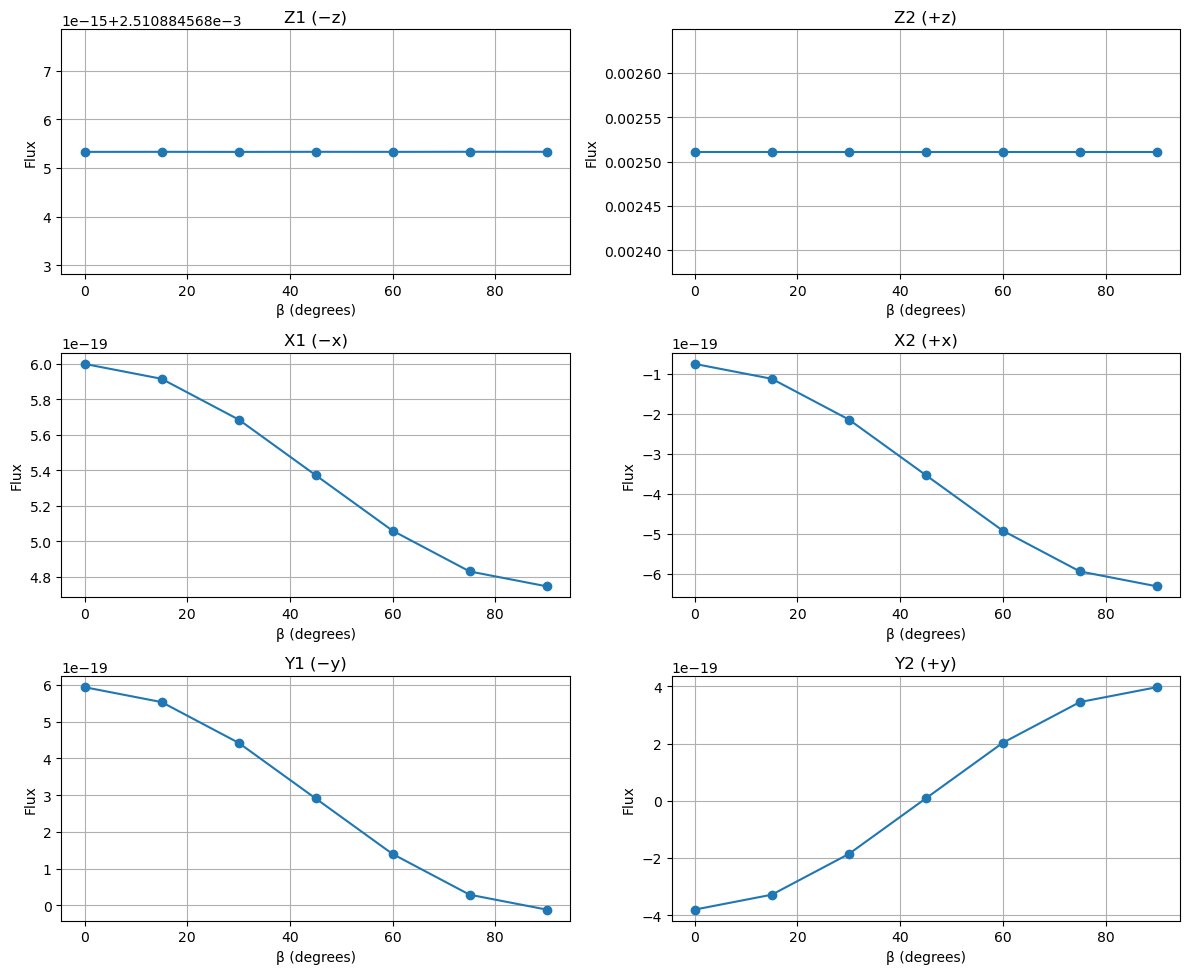

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to scalar values if needed
def scalar(val):
    return val.item() if isinstance(val, np.ndarray) else val


# Extract data
betas = [scalar(entry['beta']) for entry in flux_results]
Z1 = [scalar(entry['Z1']) for entry in flux_results]
Z2 = [scalar(entry['Z2']) for entry in flux_results]
X1 = [scalar(entry['X1']) for entry in flux_results]
X2 = [scalar(entry['X2']) for entry in flux_results]
Y1 = [scalar(entry['Y1']) for entry in flux_results]
Y2 = [scalar(entry['Y2']) for entry in flux_results]


# Set up subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

# Plot each component
labels = ['Z1 (−z)', 'Z2 (+z)', 'X1 (−x)', 'X2 (+x)', 'Y1 (−y)', 'Y2 (+y)']
values = [Z1, Z2, X1, X2, Y1, Y2]

for i, (label, val) in enumerate(zip(labels, values)):
    axs[i].plot(betas, val, marker='o')
    axs[i].set_title(label)
    axs[i].set_xlabel("β (degrees)")
    axs[i].set_ylabel("Flux")
    axs[i].grid(True)

# Hide unused subplot if any
if len(axs) > len(labels):
    axs[-1].axis('off')

plt.tight_layout()
plt.show()


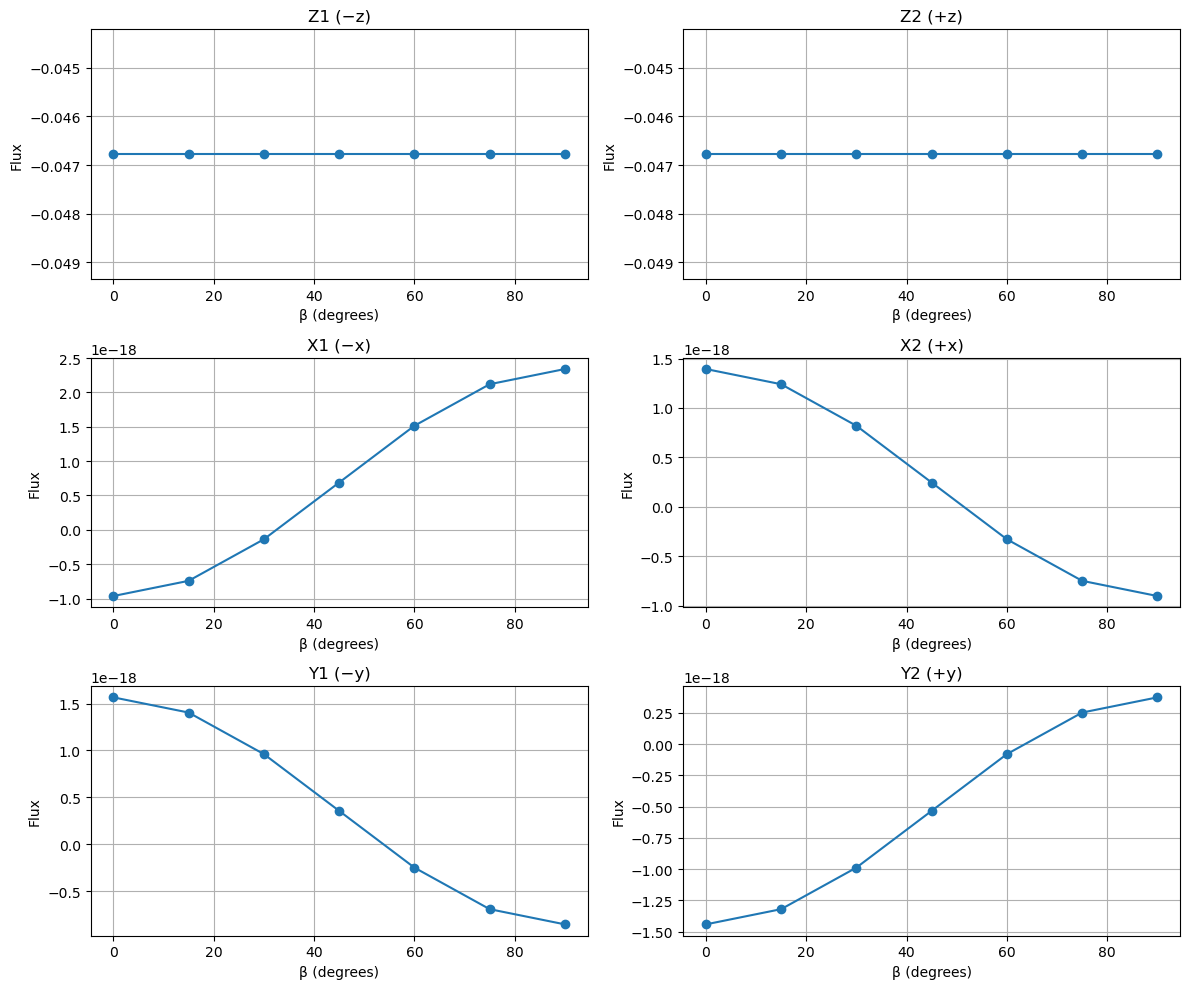

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to scalar values if needed
def scalar(val):
    return val.item() if isinstance(val, np.ndarray) else val

# Extract data
betas = [scalar(entry['beta']) for entry in inc_flux_results]
Z1 = [scalar(entry['Z1']) for entry in inc_flux_results]
Z2 = [scalar(entry['Z2']) for entry in inc_flux_results]
X1 = [scalar(entry['X1']) for entry in inc_flux_results]
X2 = [scalar(entry['X2']) for entry in inc_flux_results]
Y1 = [scalar(entry['Y1']) for entry in inc_flux_results]
Y2 = [scalar(entry['Y2']) for entry in inc_flux_results]


# Set up subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

# Plot each component
labels = ['Z1 (−z)', 'Z2 (+z)', 'X1 (−x)', 'X2 (+x)', 'Y1 (−y)', 'Y2 (+y)']
values = [Z1, Z2, X1, X2, Y1, Y2]

for i, (label, val) in enumerate(zip(labels, values)):
    axs[i].plot(betas, val, marker='o')
    axs[i].set_title(label)
    axs[i].set_xlabel("β (degrees)")
    axs[i].set_ylabel("Flux")
    axs[i].grid(True)

# Hide unused subplot if any
if len(axs) > len(labels):
    axs[-1].axis('off')

plt.tight_layout()
plt.show()
